In [1]:
%load_ext autoreload
%autoreload 2
import seaborn as sns 
sns.set_theme()

Shape of paths:  torch.Size([10000, 61, 2])
Shape of information:  torch.Size([10000, 61, 2])


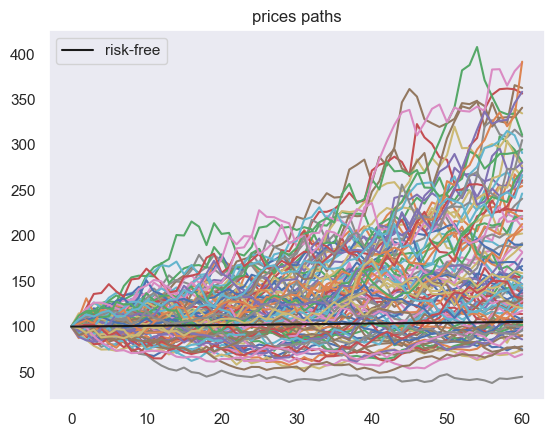

In [2]:
from neuralhedge.data.market import BS_Market
from neuralhedge.utils.plotting import plot_manage_ds
bs_market = BS_Market(n_timestep=60, dt=1/12, r=0.01)
ds_train = bs_market.get_manage_ds()
plot_manage_ds(ds_train)

In [3]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch

from neuralhedge.data.base import ManagerDataset
from neuralhedge.nn.blackschole import (BlackScholesAlpha,
                                        BlackScholesMeanVarianceAlpha,
                                        BlackScholesMeanVarianceAlphaClip)
from neuralhedge.nn.datamanager import Manager, WealthManager
from neuralhedge.nn.loss import log_utility
from neuralhedge.utils.evaluation import evaluate_mv

class BlackScholesMeanVarianceAlphaBiClip(BlackScholesMeanVarianceAlpha):
    def __init__(self, mu, sigma, r, Wstar, clip):
        super().__init__(mu, sigma, r, Wstar)
        self.clip = clip

    def forward(self, x):
        alpha = self.compute_alpha(x)

        alpha_clip = alpha * torch.logical_and(alpha < self.clip, alpha > -self.clip) + self.clip * (alpha >= self.clip) - self.clip * (alpha <= -self.clip)

        alpha_clip = alpha
        prop = torch.cat([alpha_clip, 1 - alpha_clip], dim=-1)
        return prop


def robust_evaluate_mv(
    hedger: Manager,
    ds: ManagerDataset,
):
    prices, info = ds.data
    with torch.no_grad():
        wealth = hedger.forward(prices, info)
        terminal_wealth = wealth[:, -1]
    # n_inf = torch.isnan(terminal_wealth).sum()
    # if n_inf > 0:
    #     print(f'Number of inf: {n_inf}')
    terminal_wealth = terminal_wealth[torch.isfinite(terminal_wealth)]
    
    mean = terminal_wealth.mean().item()
    var = terminal_wealth.var().item()
    return mean, var

def efficient_frontier(sigma, strategy_name):
    bs_market = BS_Market(n_timestep=60, dt=1/12, r=0.01, sigma = sigma)
    ds_test = bs_market.get_manage_ds()

    mean_var = defaultdict(list)

    def strategyBSmv(strategy):
        manager = WealthManager(strategy, utility_func=log_utility)
        mean, var = robust_evaluate_mv(manager,ds_test)
        mean_var['mean'].append(mean)
        mean_var['var'].append(var)
        return mean_var

    if strategy_name == 'constant':
        for alpha in np.linspace(0, 5, 101):
            strategy = BlackScholesAlpha(mu=bs_market.mu, sigma = bs_market.sigma, r=bs_market.r,alpha = alpha)
            mean_var = strategyBSmv(strategy)
    elif strategy_name == 'optimal':
        for Wstar in np.linspace(1, 15, 101):
            strategy = BlackScholesMeanVarianceAlpha(mu=bs_market.mu, sigma = bs_market.sigma, r=bs_market.r,Wstar=Wstar)
            mean_var = strategyBSmv(strategy)
    elif strategy_name == 'optimal_clip':
        for Wstar in np.linspace(1, 15, 101):
            strategy = BlackScholesMeanVarianceAlphaBiClip(mu=bs_market.mu, sigma = bs_market.sigma, r=bs_market.r,Wstar=Wstar, clip=5)
            mean_var = strategyBSmv(strategy)
            
    return mean_var

In [4]:
from collections import defaultdict
from tqdm import tqdm
sigma_mean_var_dict = defaultdict(dict)
sigma_range = np.linspace(0.15,0.45,7)
for sigma in tqdm(sigma_range):
    for strategy_name in ['constant','optimal', 'optimal_clip']:
        sigma_mean_var_dict[sigma][strategy_name] = efficient_frontier(sigma,strategy_name)

100%|██████████| 7/7 [00:41<00:00,  5.99s/it]


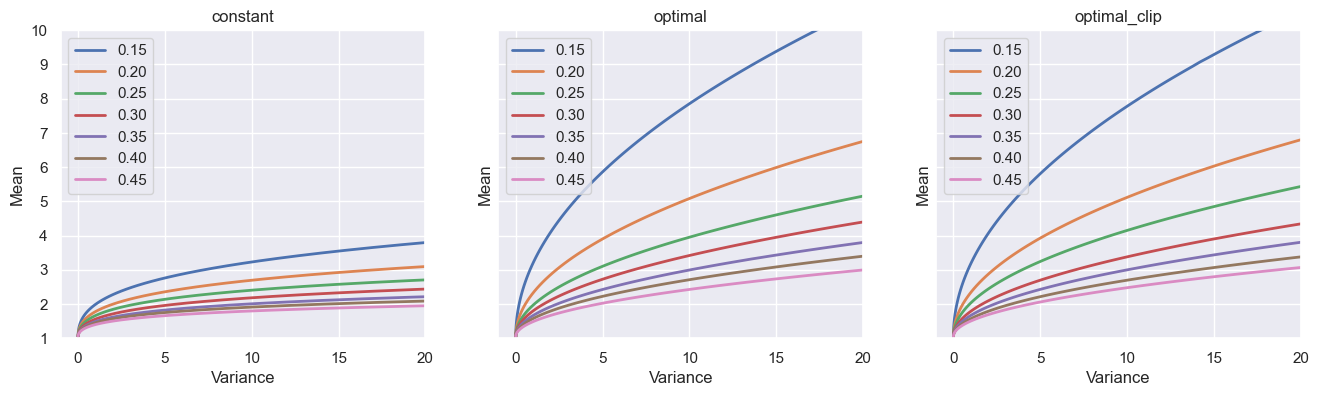

In [10]:
fig, axes = plt.subplots(1,3,figsize = [16,4], sharey=True, sharex=True)
ax_flat = axes.flatten()  # type: ignore
for sigma, strategy_dict in sigma_mean_var_dict.items():
    for i, (strategy_name, mean_var) in enumerate(strategy_dict.items()):
        axi = ax_flat[i]
        ax_flat[i].plot(mean_var['var'], mean_var['mean'], linestyle='-',linewidth=2, label = f'{sigma:.2f}')
        ax_flat[i].legend()
        ax_flat[i].set_title(strategy_name)
        ax_flat[i].set_xlim(-1, 20)
        ax_flat[i].set_ylim(1, 10)
        ax_flat[i].legend(loc = 'upper left')
        axi.set_xlabel('Variance')
        axi.set_ylabel('Mean')
